In [1]:
import pandas as pd
import numpy as np

from textblob import TextBlob
import sys
sys.path.append('scripts/')
from utility import *
import spacy
nlp = spacy.load("en_core_web_sm") # English Model
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS # stop words
spacy_stopwords.remove('not') # words to keep

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("whitegrid")

%matplotlib inline

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/Skyrim_Reviews.csv', usecols=['review', 'rating'])
data.head()

,rating,review
0,Recommended,"This is the game the never, ever ends. I picke..."
1,Recommended,Ruined my life. Five stars.
2,Recommended,I was stacking books on a shelf in my house in...
3,Recommended,"Best game I ever bought. In this game, you'll ..."
4,Recommended,Playing Skyrim is like masturbating. Feels goo...


In [3]:
categories = list(zip(data['rating'].value_counts()[:],  data['rating'].value_counts().index))
num_reviews = data['review'].shape[0]

print(f'Dataset consists of {num_reviews} reviews with {categories}')

Dataset consists of 7165 reviews with [(3651, 'Not Recommended'), (3514, 'Recommended')]


## EDA

In [4]:
def custom_sentencizer(doc):
    
    boundary = re.compile('\.{2,}')
    digits = re.compile('^[0-9]*$')
    
    for token in doc[:-1]:
        if boundary.match(token.text) or digits.match(token.text) or token.text in [',', '!', '?', ':', 'and']:
            doc[token.i+1].is_sent_start = False
                
    return doc

In [5]:
nlp.add_pipe(custom_sentencizer, before="parser")

In [9]:
def most_positive_sentence(text):
    
    sentences = sentence_tokenize(text)
    polarity = []
    
    for sentence in sentences:
        polarity.append(TextBlob(str(sentence)).sentiment.polarity)
    
    if np.max(polarity) >= 0.9:
        return sentences[np.argmax(polarity)]
    else:
        return None

In [10]:
def most_negative_sentence(text):
    
    sentences = sentence_tokenize(text)
    polarity = []
    
    for sentence in sentences:
        polarity.append(TextBlob(str(sentence)).sentiment.polarity)
    
    if np.min(polarity) < -0.9:
        return sentences[np.argmin(polarity)]
    else:
        return None

In [11]:
data['review_visual'] = normalise_text(data['review'], All=False, expand_contraction=True, remove_white_spaces=True)

In [12]:
worst = []
for review in data['review_visual']:
    sent = most_negative_sentence(review)
    if sent:
        worst.append(sent)

In [13]:
best = []
for review in data['review_visual']:
    sent = most_positive_sentence(review)
    if sent:
        best.append(sent)

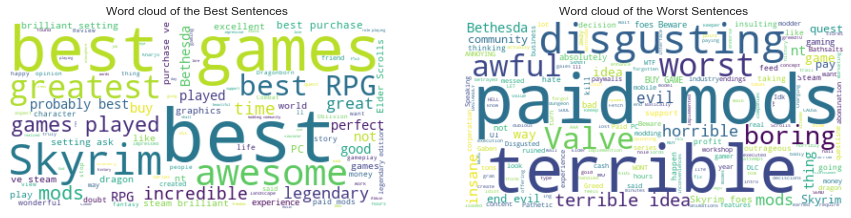

In [14]:
titles = ['Best Sentences', 'Worst Sentences']
texts = [best, worst]

fig, axis = plt.subplots(1, 2, figsize=(15,10))

for i, text in enumerate(texts):
    text = ' '.join([str(sentence) for sentence in text])
    text = remove_special_characters(text)
    
    wordcloud = WordCloud(stopwords=spacy_stopwords, background_color="white").generate(text)


    axis[i].imshow(wordcloud, interpolation='bilinear')
    axis[i].set_title(f'Word cloud of the {titles[i]}')
    axis[i].axis("off")

# Feature Engineering

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data['ratings'] = le.fit_transform(data['rating'])
data['ratings'].value_counts()

0    3651
1    3514
Name: ratings, dtype: int64

In [7]:
# Word Count
data['char_count'] = data['review'].apply(len)
# Character Count
data['word_count'] = data['review'].apply(lambda text: len(tokenize(text)))
# Punctuation count
data['punctuation_count'] = data['review'].apply(lambda text: count_punct(text))
# Upper Case count
data['upper_case_word_count'] = data['review'].apply(lambda text: count_upper(text))

In [8]:
# POS type counts
data['noun_count'] = data['review'].apply(lambda text: count_pos_type(text, 'noun'))
data['verb_count'] = data['review'].apply(lambda text: count_pos_type(text, 'verb'))
data['adj_count'] = data['review'].apply(lambda text: count_pos_type(text, 'adjective'))
data['adv_count'] = data['review'].apply(lambda text: count_pos_type(text, 'adverb'))
data['pron_count'] = data['review'].apply(lambda text: count_pos_type(text, 'pronoun'))

In [9]:
cols = ['char_count','word_count','punctuation_count','upper_case_word_count','noun_count','verb_count','adj_count','adv_count','pron_count','ratings']

## Word Embedding

In [12]:
data['norm_review'] = normalise_text(data['review'], All = True, remove_digit=True, stopword=spacy_stopwords)

In [13]:
corpus = data['norm_review']

### Count Vector

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer(tokenizer = tokenize, ngram_range=(1,1), min_df=1)
data_count_vec = count_vector.fit_transform(corpus)

In [42]:
data_count = pd.DataFrame(data_count_vec.toarray(), columns=count_vector.get_feature_names())
data_count = pd.concat([data_count, data[cols]], axis=1)

### TF-IDF Vector

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer = tokenize, ngram_range=(1,1))
data_tfidf_vec = tfidf_vector.fit_transform(corpus)

In [54]:
data_tfidf = pd.DataFrame(data_tfidf_vec.toarray(), columns=tfidf_vector.get_feature_names())
data_tfidf = pd.concat([data_tfidf, data[cols]], axis=1)

# Model

In [43]:
from sklearn.model_selection import train_test_split

X = data_count.drop(['ratings'], axis = 1)
y = data_count['ratings']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

logist_model = Pipeline([
                  ('logist' , LogisticRegression())
                 ])

rf_model = Pipeline([
                  ('rf' , RandomForestClassifier())
                 ])

nb_model = Pipeline([
                  ('gnb' , GaussianNB())
                 ])

In [44]:
from sklearn.model_selection import cross_val_score

models = [logist_model, rf_model, nb_model]

for model in models:
    model_name = list(model.named_steps.keys())
    scores = cross_val_score(model, X_train, y_train, cv=3)
    
    print(f'Accuracy of {model_name} classifier on train set: {scores.mean(): 0.2f} +/- {scores.std() * 2: 0.2f}')

Accuracy of ['logist'] classifier on train set:  0.92 +/-  0.00
Accuracy of ['rf'] classifier on train set:  0.89 +/-  0.01
Accuracy of ['gnb'] classifier on train set:  0.67 +/-  0.02


In [119]:
logist_model.fit(X_train, y_train)
y_pred = logist_model.predict(X_test)
probs = logist_model.predict_proba(X_test)
y_score = probs[:,1]

## Model Evaluation

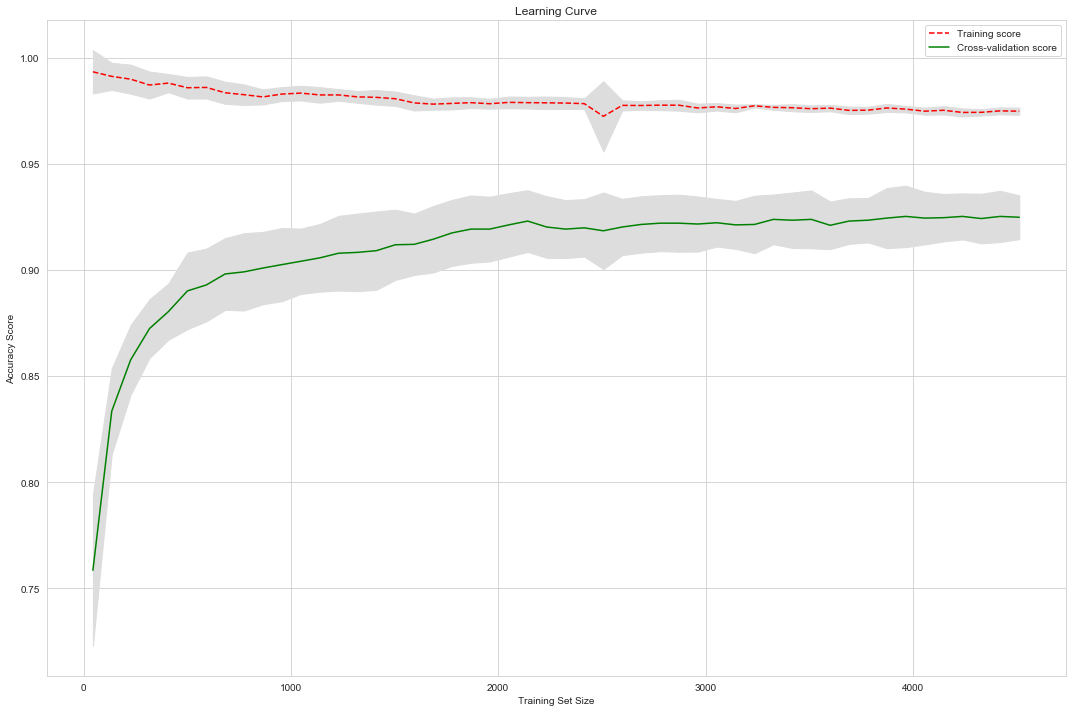

In [125]:
# Learning Curve
def learning_curve(model, x_train, y_train):
    
    from sklearn.model_selection import learning_curve
    
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X_train, 
                                                            y_train,
                                                            # Number of folds in cross-validation
                                                            cv=10,
                                                            # Evaluation metric
                                                            scoring='accuracy',
                                                            # Use all computer cores
                                                            n_jobs=-1, 
                                                            # 50 different sizes of the training set
                                                            train_sizes=np.linspace(0.01, 1.0, 50),
                                                            # shuffle
                                                            shuffle=True,
                                                            random_state=RANDOM_STATE)
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.rcParams["figure.figsize"] = [15,10]
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
    plt.plot(train_sizes, test_mean, color="green", label="Cross-validation score")
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    
    plt.tight_layout()
    
learning_curve(logist_model, X_train, y_train)

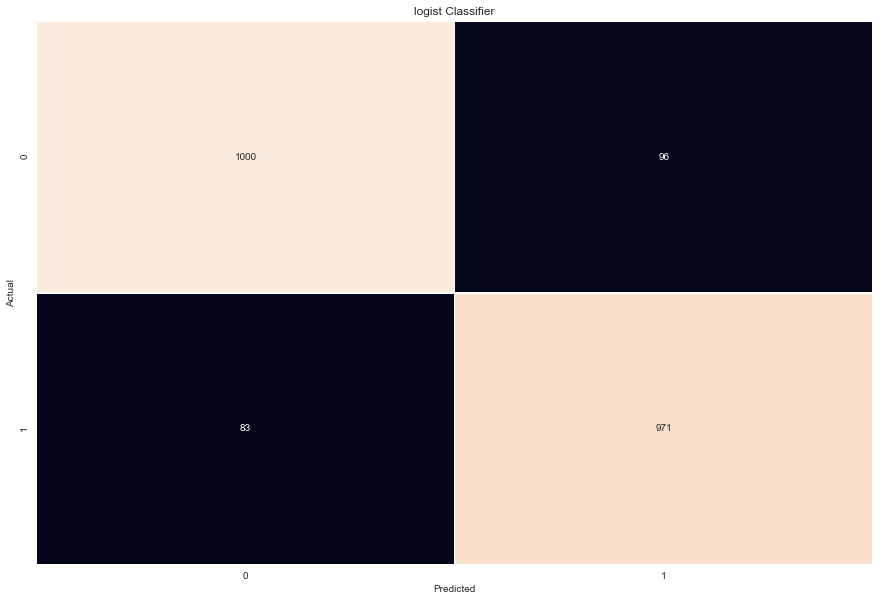

In [46]:
def confusion_matrix(model, y_pred):
    from sklearn.metrics import confusion_matrix
    
    model_name = list(model.named_steps.keys())
    confusion = confusion_matrix(y_test, y_pred)
    
    fig, axis = plt.subplots(figsize=(15,10))
    axis = sns.heatmap(confusion, annot=True, fmt="d", linewidths=0.5, cbar=False)
    axis.set(xlabel='Predicted', ylabel='Actual')
    axis.set_title(f'{model_name[0]} Classifier')
    
confusion_matrix(logist_model, y_pred)

In [47]:
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, roc_curve, classification_report

np.round(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T, 2)

,precision,recall,f1-score,support
0,0.92,0.91,0.92,1096.00
1,0.91,0.92,0.92,1054.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.92,0.92,0.92,2150.00
weighted avg,0.92,0.92,0.92,2150.00


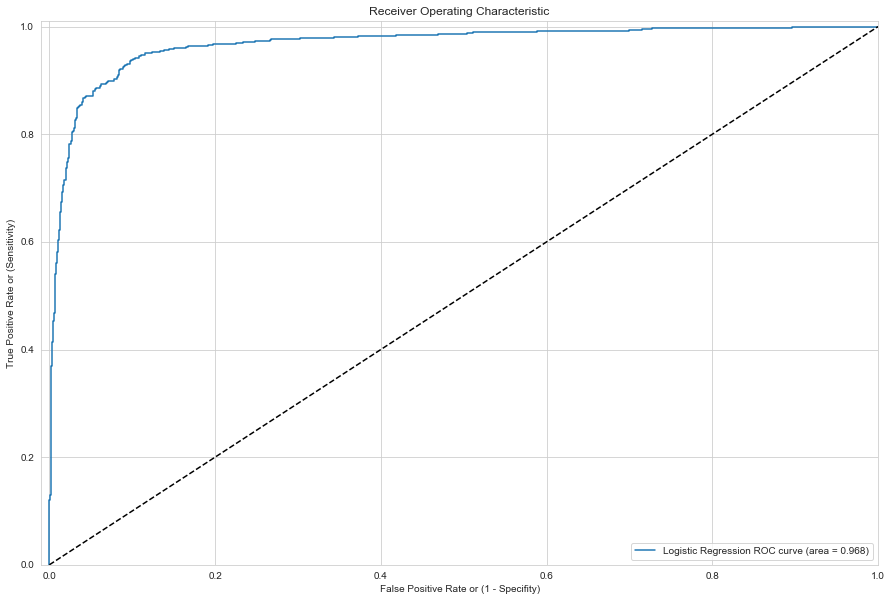

In [48]:
def ROC_curve(model_name: str, y_score):
    
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, label=f'{model_name} ROC curve (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
ROC_curve('Logistic Regression', y_score)

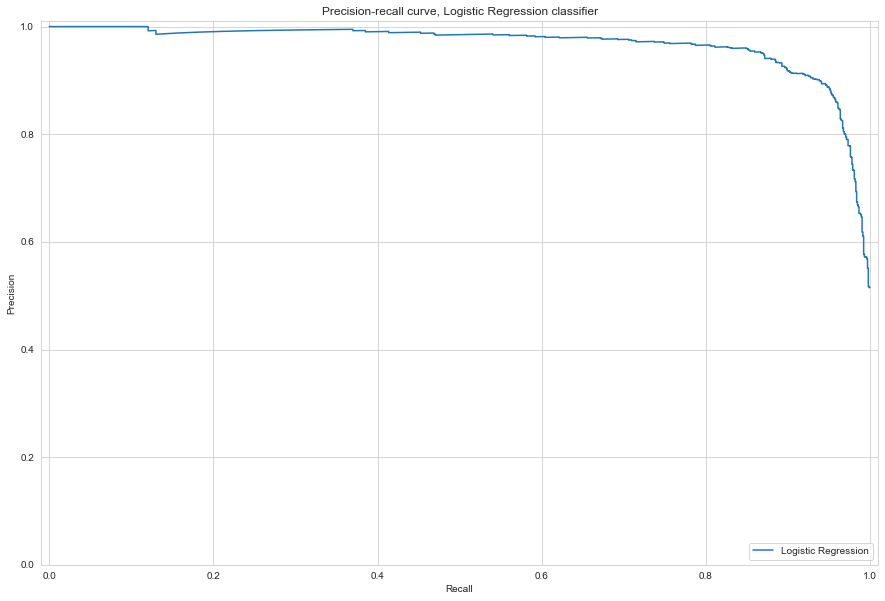

In [49]:
def PR_curve(model_name: str, y_score, y_test):
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    plt.figure(figsize=(15,10))
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-recall curve, {model_name} classifier')
    plt.legend(loc="lower right")
    
PR_curve('Logistic Regression', y_score, y_test)

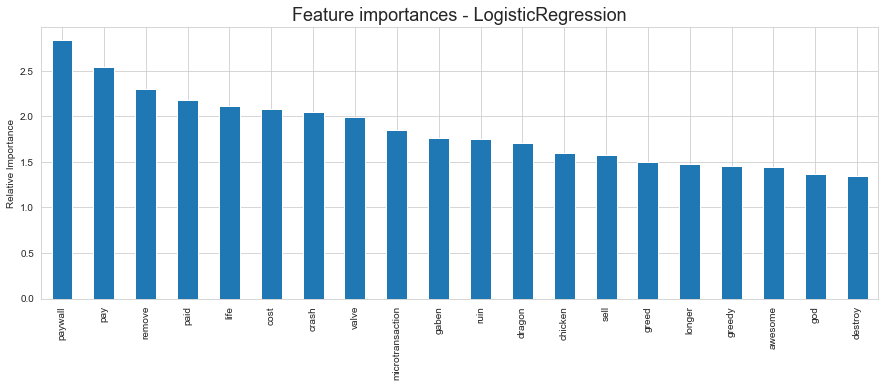

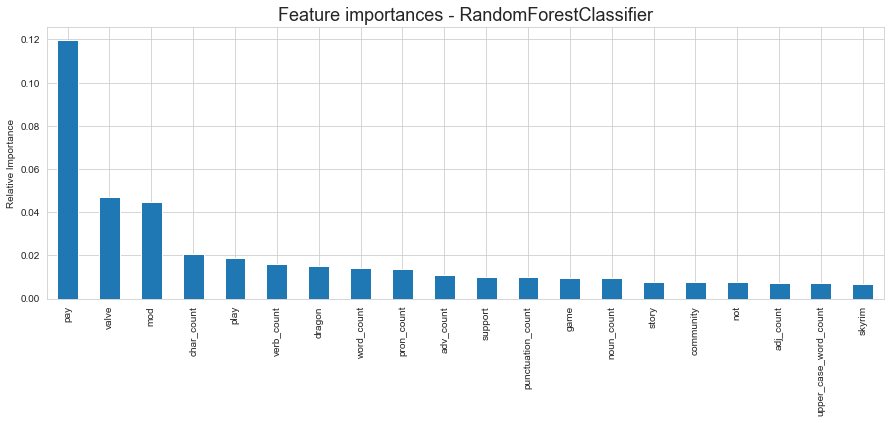

In [124]:
def plot_feature_importance(model, data, n_words=20):
    
    if 'feature_importances_' in dir(model):
        importance = model.feature_importances_
    elif 'coef_' in dir(model):
        importance = abs(np.array(model.coef_).ravel())
    else:
        return None
        
    feature_importances = pd.DataFrame(importance,
                                   index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    
    name = remove_special_characters(str(model.__class__).split('.')[-1])
    
    fig, axis = plt.subplots(1, 1, figsize=(15,5))
    
    feature_importances[:n_words].plot.bar(ax=axis, legend=False)
    plt.title(f'Feature importances - {name}', fontsize=18)
    plt.ylabel('Relative Importance')

for model in models:
    plot_feature_importance(model.steps[0][1], X, 20)